In [2]:
import os
import gc
import sys
import torch
import scipy
import psutil
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, set_image_backend

import data_utils
import train_utils
import model_utils

%reload_ext autoreload
%autoreload 2

set_image_backend('accimage')

In [3]:
'''
KIRC_10x_results_baseline_slidelevel_val.txt
KIRC_10x_results_maml_slidelevel_val.txt
LIHC_10x_results_baseline_slidelevel_val.txt
LIHC_10x_results_maml_slidelevel_val.txt
UCEC_results_baseline_slidelevel_val.txt
UCEC_results_maml_slidelevel_val.txt
'''

'\nKIRC_10x_results_baseline_slidelevel_val.txt\nKIRC_10x_results_maml_slidelevel_val.txt\nLIHC_10x_results_baseline_slidelevel_val.txt\nLIHC_10x_results_maml_slidelevel_val.txt\nUCEC_results_baseline_slidelevel_val.txt\nUCEC_results_maml_slidelevel_val.txt\n'

In [68]:
baseline = 'KIRC_10x_results_baseline_slidelevel_val.txt'
maml = 'KIRC_10x_results_maml_slidelevel_val.txt'
df1 = pd.read_csv(baseline,sep='\t',index_col='slide_id')
df4 = pd.read_csv(maml,sep='\t',index_col='slide_id')


baseline = 'LIHC_10x_results_baseline_slidelevel_val.txt'
maml = 'LIHC_10x_results_maml_slidelevel_val.txt'
df2 = pd.read_csv(baseline,sep='\t',index_col='slide_id')
df5 = pd.read_csv(maml,sep='\t',index_col='slide_id')

baseline = 'UCEC_results_baseline_slidelevel_val.txt'
maml = 'UCEC_results_maml_slidelevel_val.txt'
df3 = pd.read_csv(baseline,sep='\t',index_col='slide_id')
df6 = pd.read_csv(maml,sep='\t',index_col='slide_id')

df_base_line = pd.concat([df1,df2,df3])
df_maml = pd.concat([df4,df5,df6])


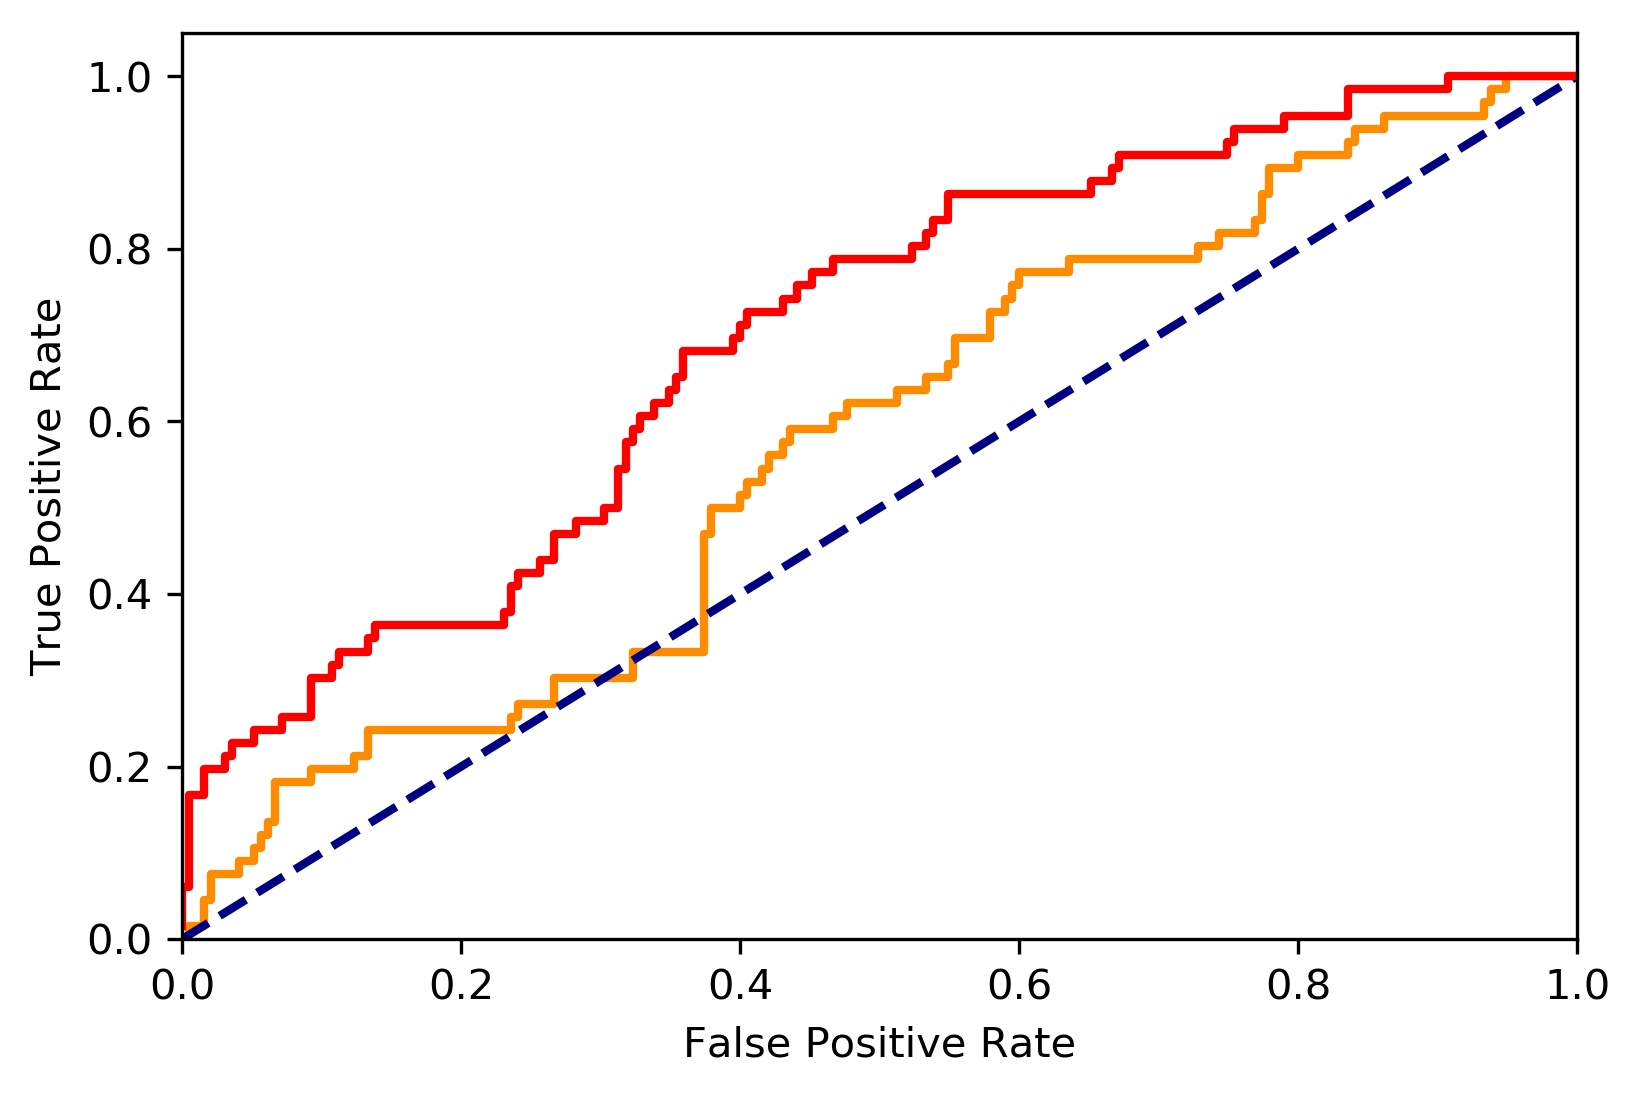

In [83]:
from sklearn import metrics
import scipy
slide_level = df_base_line
fpr, tpr, thresholds = metrics.roc_curve(np.array(slide_level['labels']), scipy.special.expit(np.array(slide_level['1'])))
roc_auc = metrics.auc(fpr, tpr)
fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Baseline (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Slide-level receiver operating characteristic (WGD)')



slide_level = df_maml
fpr, tpr, thresholds = metrics.roc_curve(np.array(slide_level['labels']), scipy.special.expit(np.array(slide_level['1'])))
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=lw, label='MAML (area = %0.2f)' % roc_auc)
#plt.legend(loc="lower right")
#plt.title('ROC after gradient step held out cancer')
fig.set_dpi(300)
plt.savefig('ROCs_comp_baseline_maml.png')


In [80]:
import scipy
def compute_roc_baseline_vs_maml(baseline,maml):
    roc_auc_base_line = []
    slide_level = pd.read_csv(baseline,sep='\t',index_col='slide_id')
    for i in range(5):
        fpr, tpr, thresholds = metrics.roc_curve(np.array(slide_level['labels']), scipy.special.expit(np.array(slide_level[str(i)])))
        roc_auc_base_line.append( metrics.auc(fpr, tpr))
    roc_auc_maml = []
    slide_level = pd.read_csv(maml,sep='\t',index_col='slide_id')
    for i in range(5):
        fpr, tpr, thresholds = metrics.roc_curve(np.array(slide_level['labels']), scipy.special.expit(np.array(slide_level[str(i)])))
        roc_auc_maml.append( metrics.auc(fpr, tpr))
    return np.stack(roc_auc_base_line),np.stack(roc_auc_maml)
def plot_compare_rocs(r_b,r_maml,cancer_type):
    fig,ax = plt.subplots(1)
    b = ax.plot(r_b,'b.-',ms=10)
    m = ax.plot(r_maml,'r.-',ms=10)
    plt.xticks([0,1,2,3,4],[0,1,2,3,4])
    plt.ylabel('AUC')
    plt.xlabel('Gradient Steps')
    plt.legend(labels=['ResNet18','MAML (1 Gradient Step)'])
    plt.title(cancer_type)
    fig.set_dpi(300)


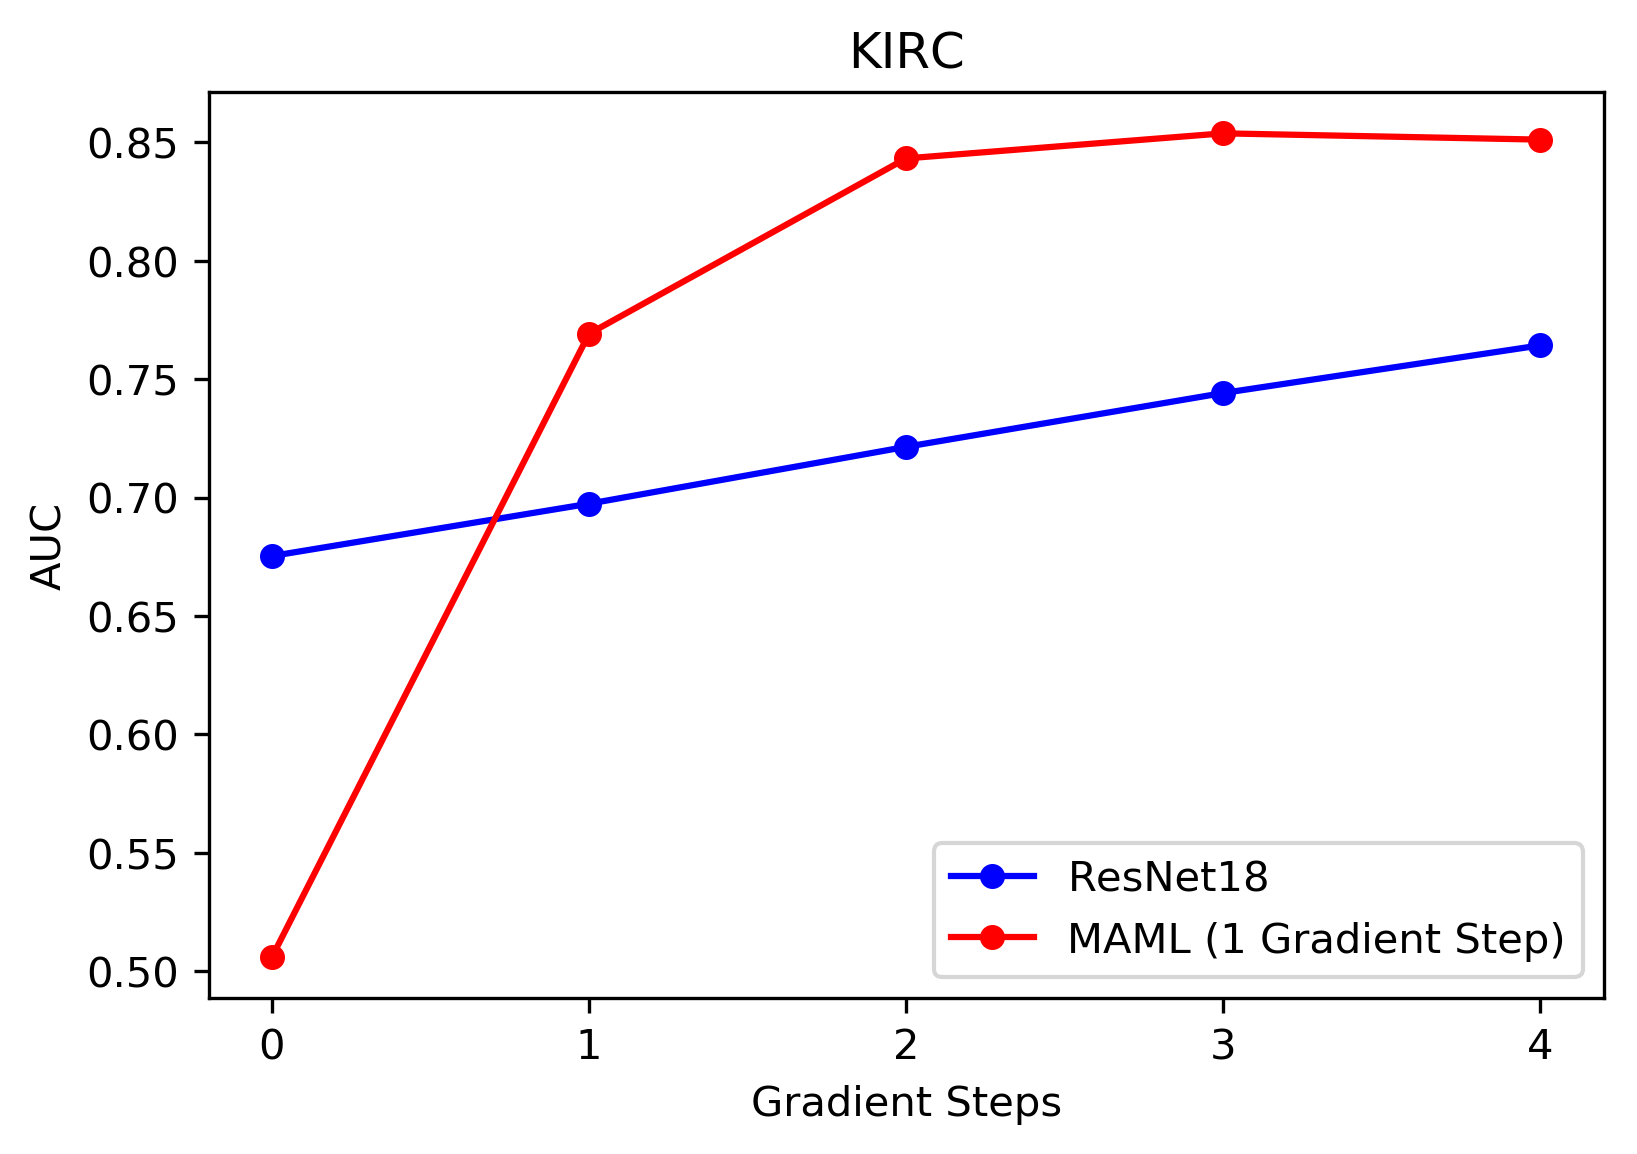

In [45]:
baseline = 'KIRC_10x_results_baseline_slidelevel_val.txt'
maml = 'KIRC_10x_results_maml_slidelevel_val.txt'
r_b_k,r_maml_k = compute_roc_baseline_vs_maml(baseline,maml)
plot_compare_rocs(r_b_k,r_maml_k,'KIRC')

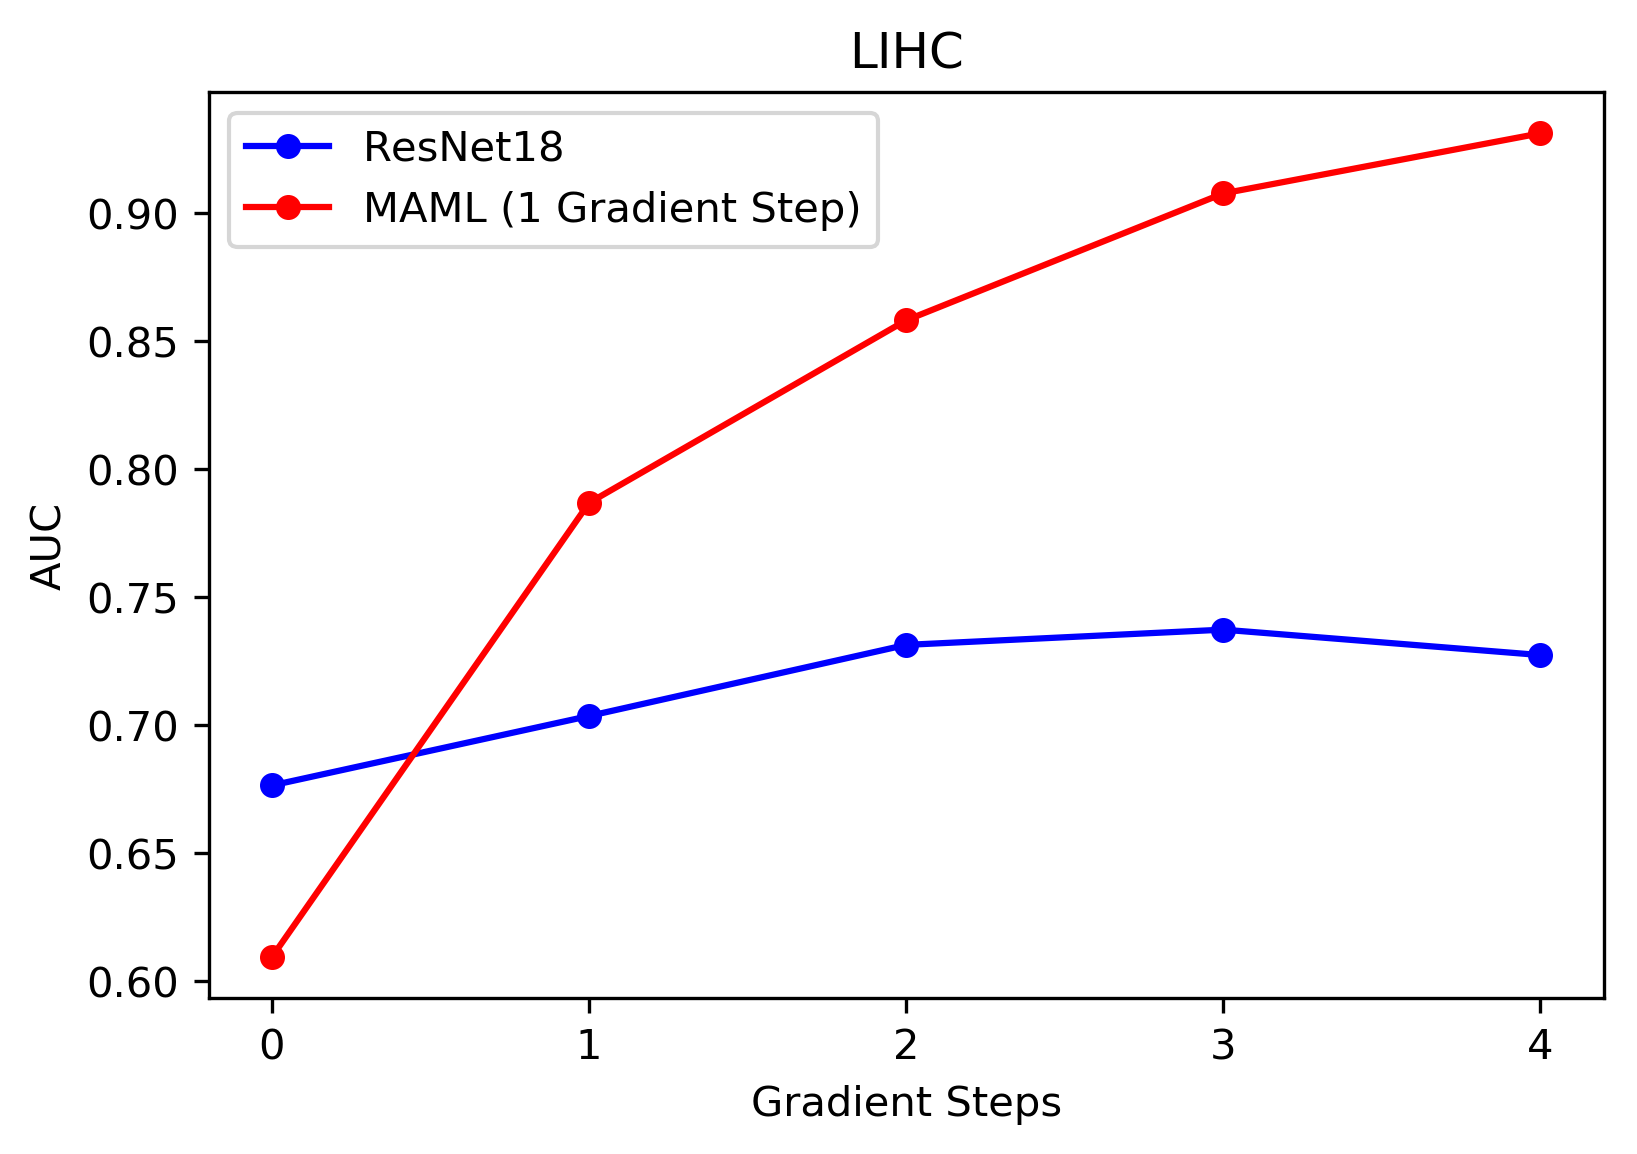

In [46]:
baseline = 'LIHC_10x_results_baseline_slidelevel_val.txt'
maml = 'LIHC_10x_results_maml_slidelevel_val.txt'
r_b_l,r_maml_l = compute_roc_baseline_vs_maml(baseline,maml)
plot_compare_rocs(r_b_l,r_maml_l,'LIHC')

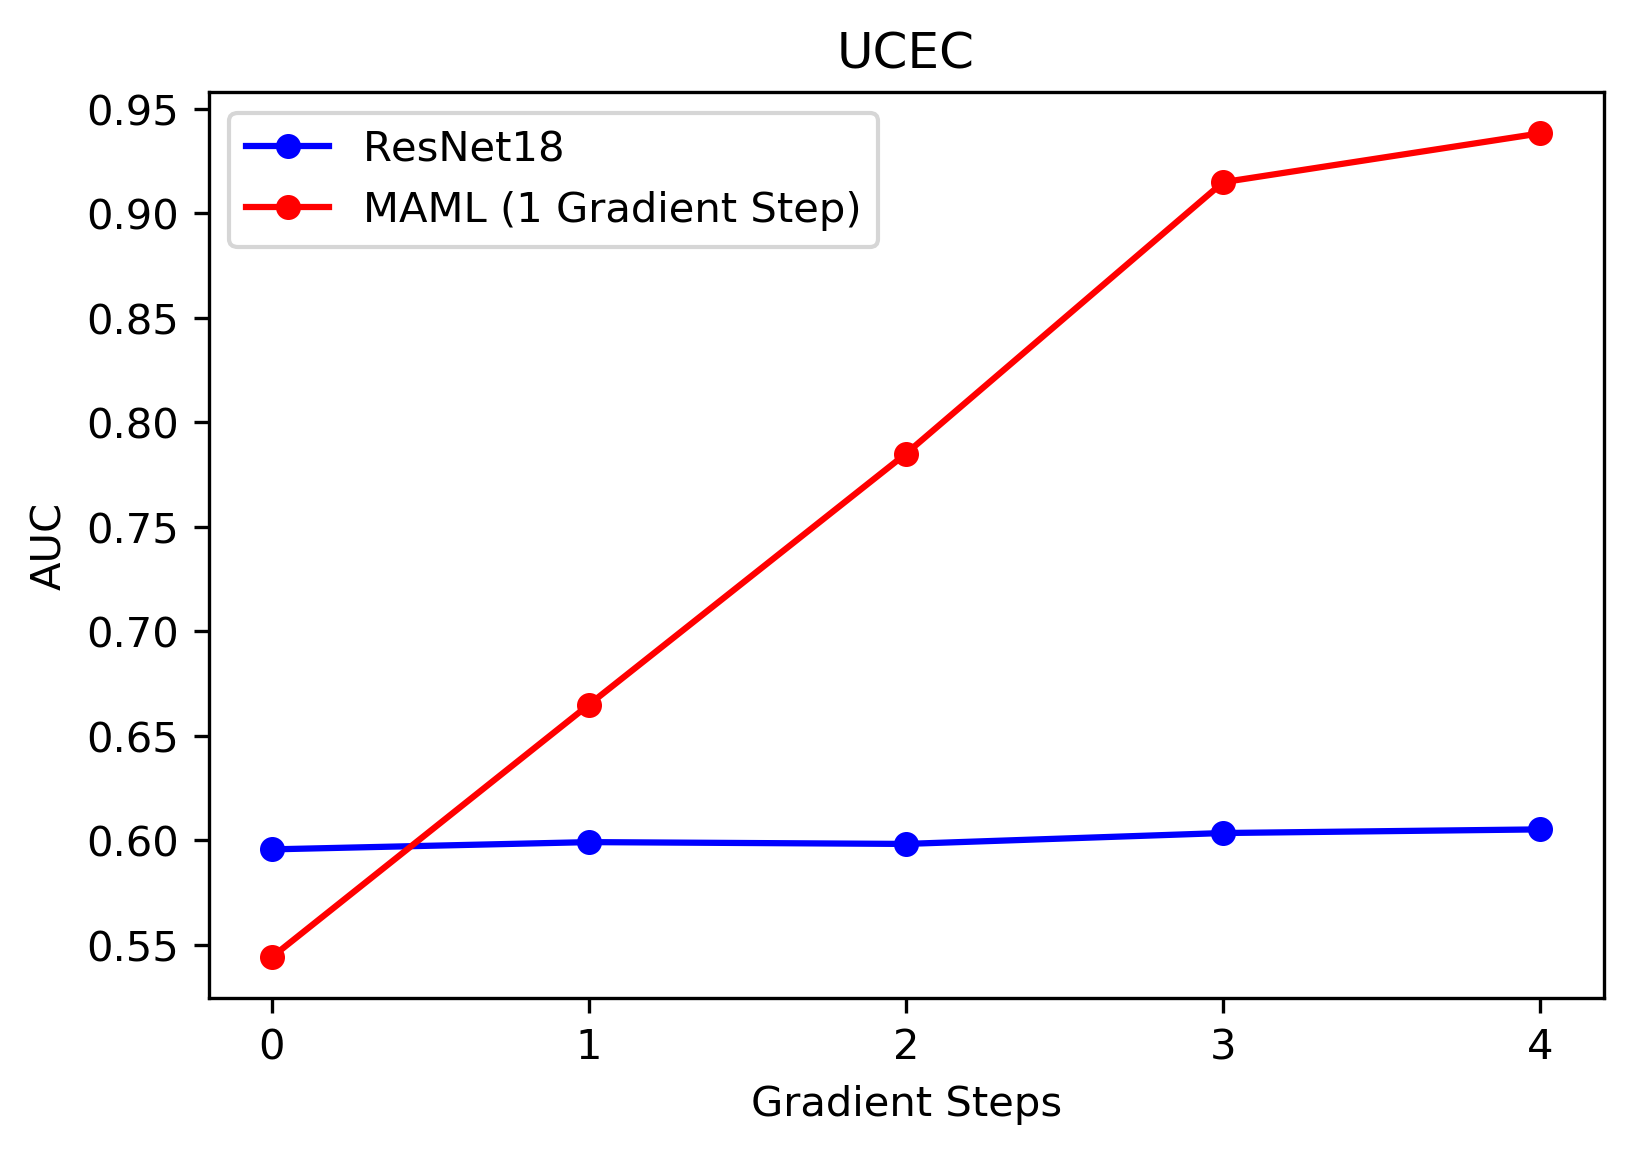

In [47]:
baseline = 'UCEC_results_baseline_slidelevel_val.txt'
maml = 'UCEC_results_maml_slidelevel_val.txt'
r_b_u,r_maml_u = compute_roc_baseline_vs_maml(baseline,maml)
plot_compare_rocs(r_b_u,r_maml_u,'UCEC')

In [52]:
b_mean = np.mean(np.stack([r_b_k,r_b_l,r_b_u]),0)
maml_mean = np.mean(np.stack([r_maml_k,r_maml_l,r_maml_u]),0)

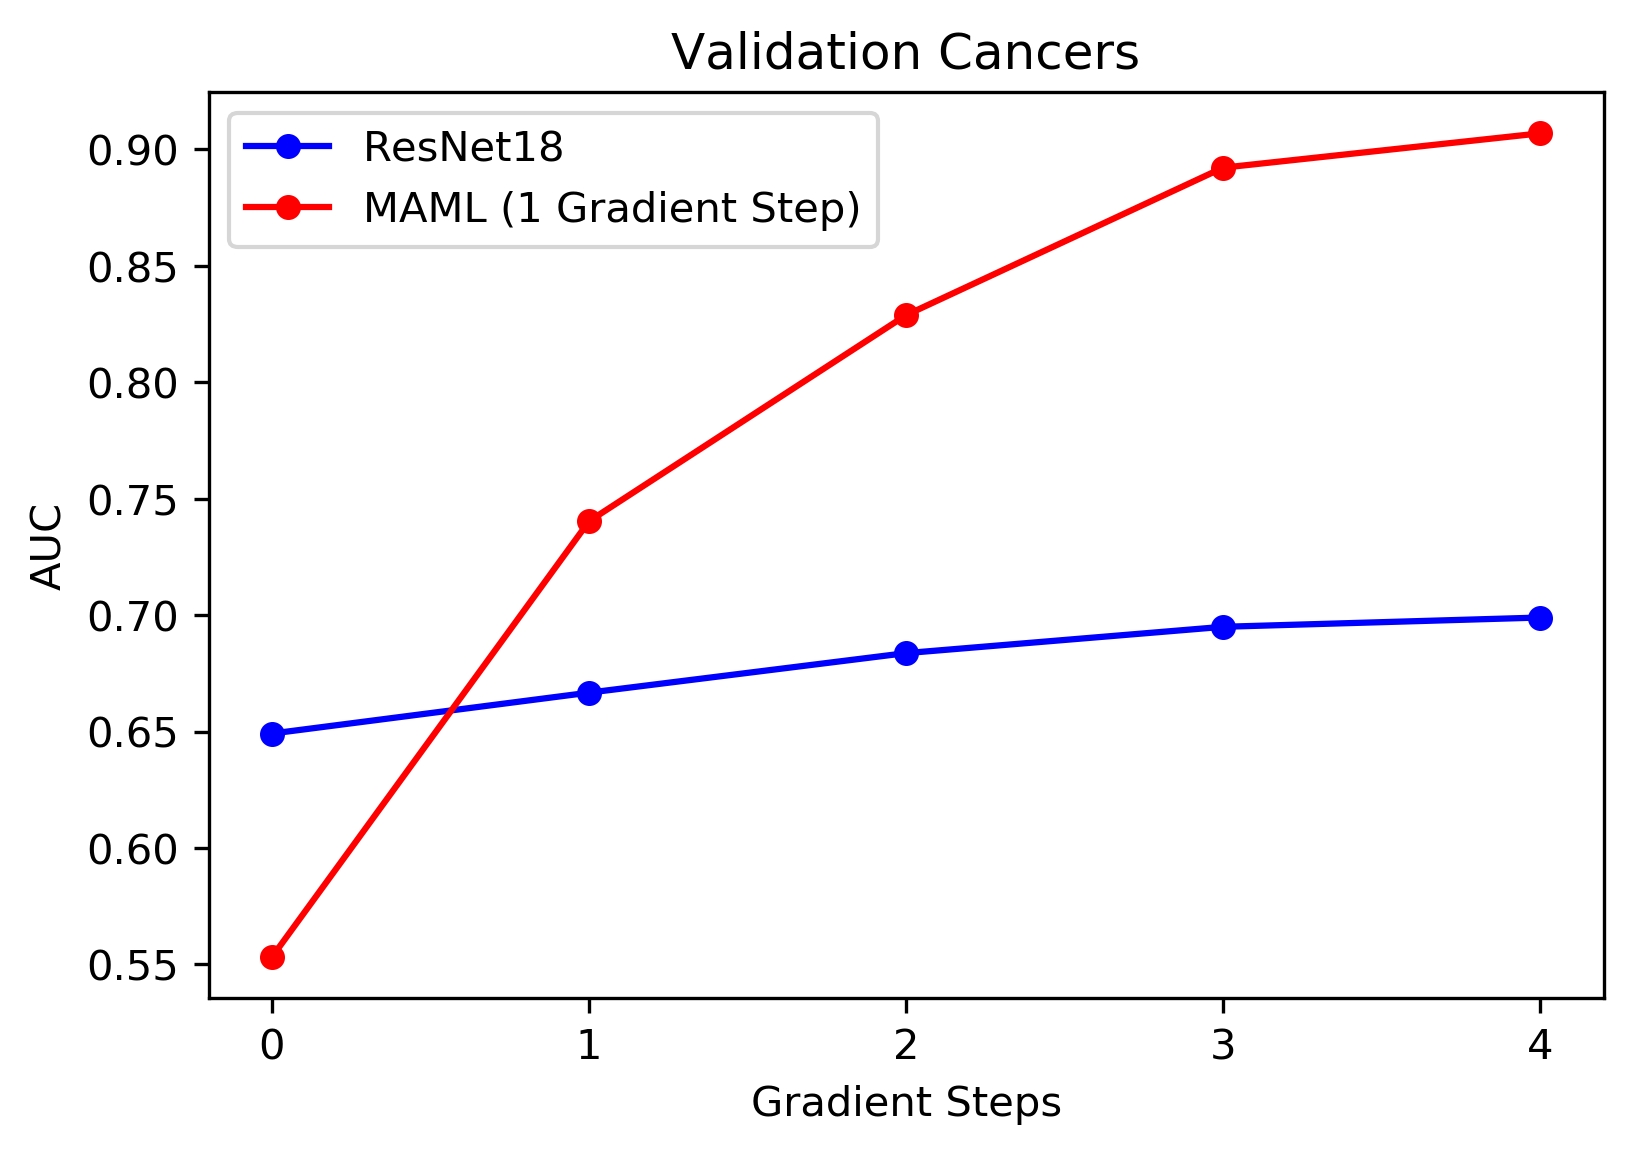

In [81]:
plot_compare_rocs(b_mean,maml_mean,'Validation Cancers')


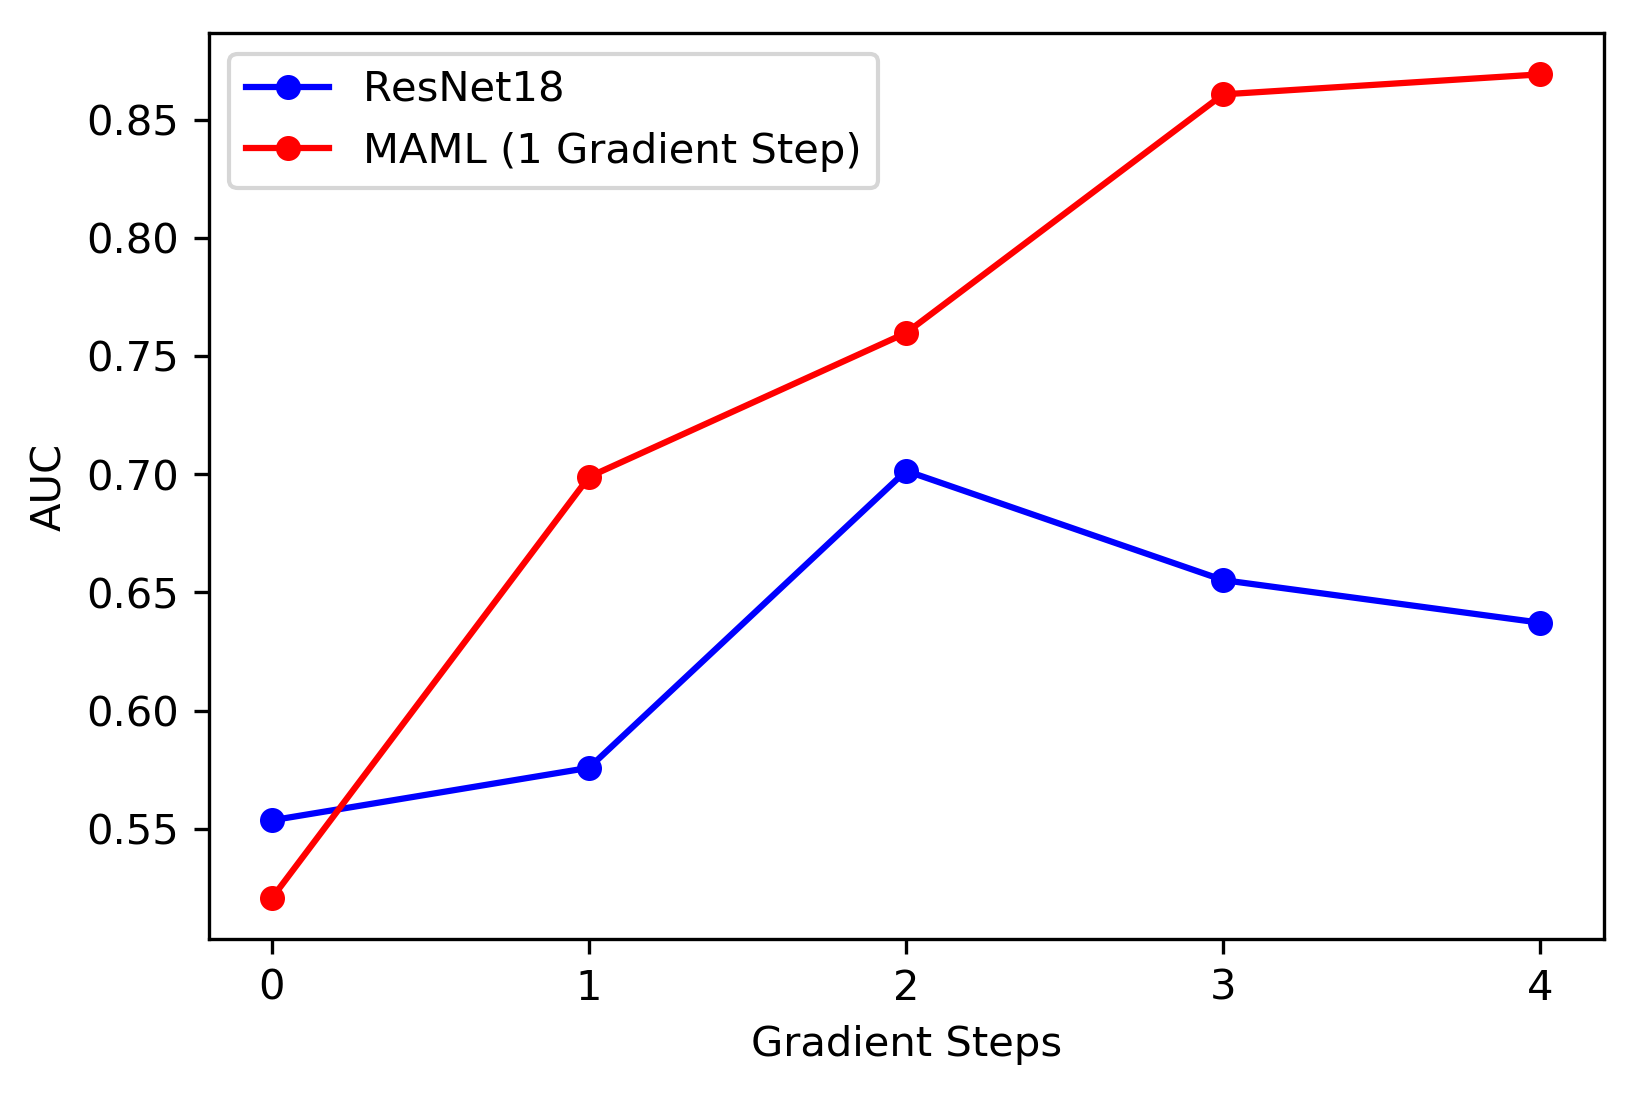

In [74]:
def compute_roc_baseline_vs_maml_dfs(df1,df2):
    roc_auc_base_line = []
    slide_level = df1
    for i in range(5):
        fpr, tpr, thresholds = metrics.roc_curve(np.array(slide_level['labels']), scipy.special.expit(np.array(slide_level[str(i)])))
        roc_auc_base_line.append( metrics.auc(fpr, tpr))
    roc_auc_maml = []
    slide_level = df2
    for i in range(5):
        fpr, tpr, thresholds = metrics.roc_curve(np.array(slide_level['labels']), scipy.special.expit(np.array(slide_level[str(i)])))
        roc_auc_maml.append( metrics.auc(fpr, tpr))
    return np.stack(roc_auc_base_line),np.stack(roc_auc_maml)
df_base_line = pd.concat([df1,df2,df3])
df_maml = pd.concat([df4,df5,df6])

r_b_u,r_maml_u = compute_roc_baseline_vs_maml_dfs(df_base_line,df_maml)
plot_compare_rocs(r_b_u,r_maml_u,'')